Imports

In [4]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Carrega Base

In [6]:
df = pd.read_csv("nelson.csv", header=[0])
df.head(5)

,Skeleton 016:LFTC X,Skeleton 016:LFTC Y,Skeleton 016:LFTC Z
0,-785.775269,958.105652,-1245.510986
1,-785.869995,958.078369,-1245.574097
2,-785.915771,958.087280,-1245.652832
3,-785.933716,958.090515,-1245.795898
4,-786.016113,958.077454,-1245.967285


Primeiras Analises

Separação em Treino, Teste e Validação

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Normalizacao

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

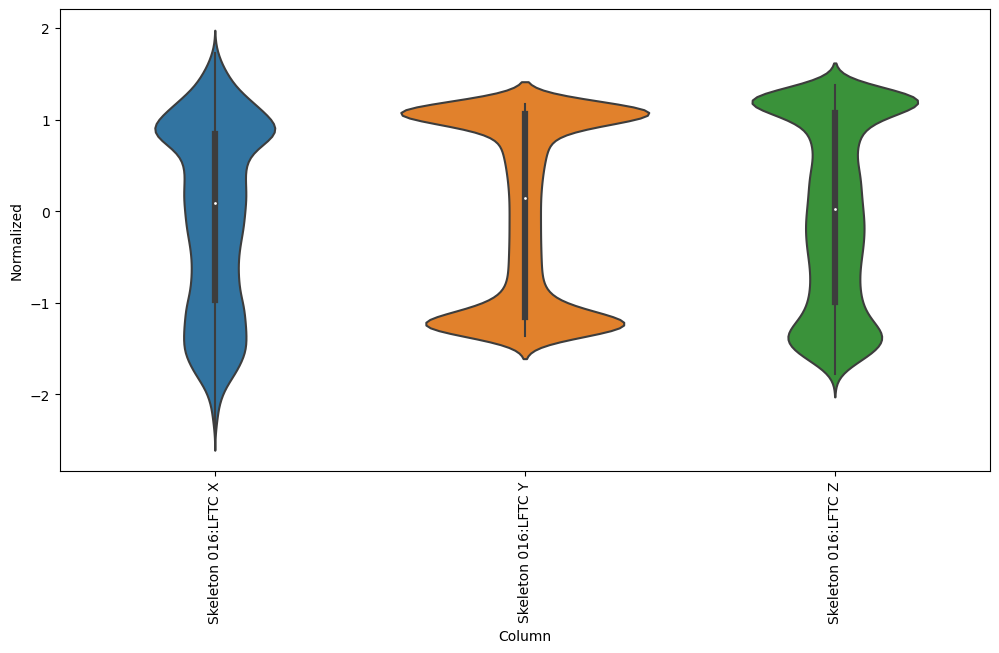

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Criador de Janelas

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

In [15]:
w1 = WindowGenerator(input_width=80, label_width=1, shift=10,
                     label_columns=['Skeleton 016:LFTC Y'])
w1

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Label indices: [89]
Label column name(s): ['Skeleton 016:LFTC Y']

In [16]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 90, 3)
Inputs shape: (3, 80, 3)
Labels shape: (3, 1, 1)


Visualizar as Janelas

In [18]:
w1.example = example_inputs, example_labels

In [19]:
def plot(self, model=None, plot_col='Skeleton 016:LFTC Y', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

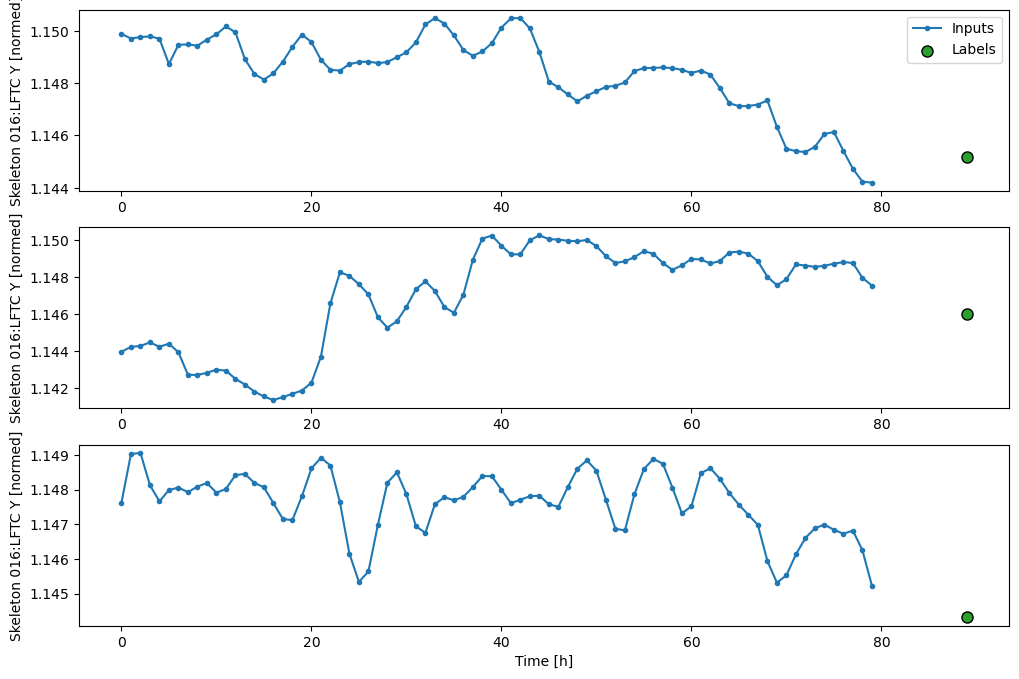

In [20]:
w1.plot(plot_col ='Skeleton 016:LFTC Y' )

In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
w1.train.element_spec

(TensorSpec(shape=(None, 80, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [24]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 80, 3)
Labels shape (batch, time, features): (32, 1, 1)


Prever Eixo Y utilizando o Eixo Y

In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Skeleton 016:LFTC Y'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Skeleton 016:LFTC Y']

In [27]:
wide_window  = WindowGenerator(
    input_width=24, label_width=24 , shift=1,
    label_columns=['Skeleton 016:LFTC Y'])
wide_window 

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Skeleton 016:LFTC Y']

Baseline

In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [30]:
baseline = Baseline(label_index=column_indices['Skeleton 016:LFTC Y'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9792e-04 - mean_absolute_error: 0.0094


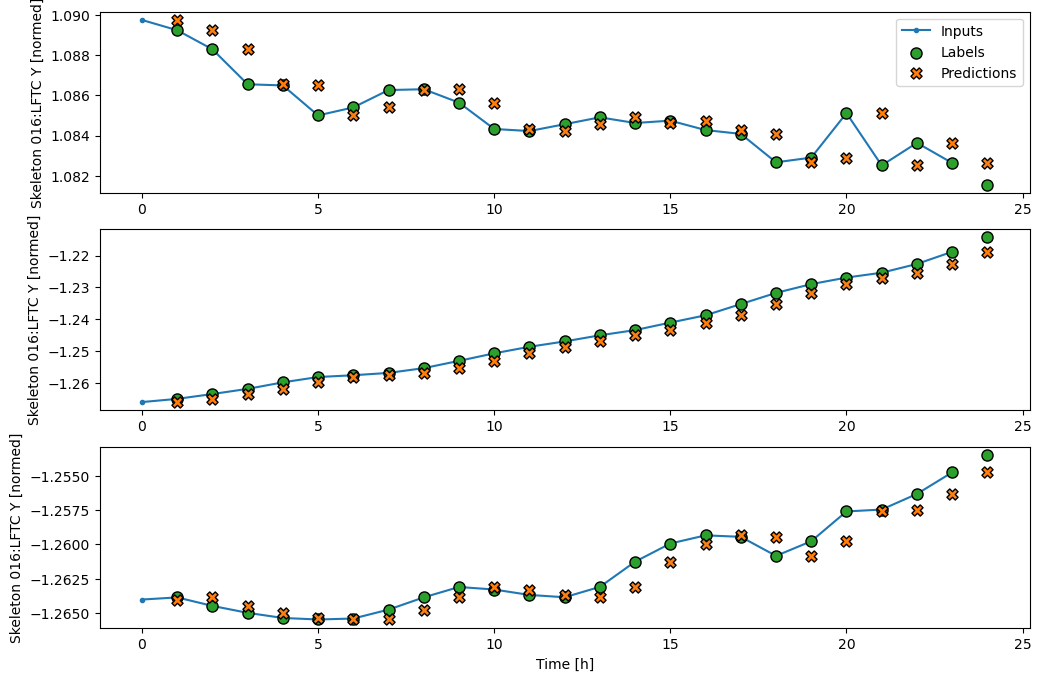

In [31]:
wide_window.plot(baseline)

Linear

In [33]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [34]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [35]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.8311 - mean_absolute_error: 2.1978 - val_loss: 1.0134 - val_mean_absolute_error: 0.9521
Epoch 2/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6078 - mean_absolute_error: 0.7102 - val_loss: 0.0816 - val_mean_absolute_error: 0.2597
Epoch 3/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0670 - mean_absolute_error: 0.2144 - val_loss: 0.0555 - val_mean_absolute_error: 0.1991
Epoch 4/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0475 - mean_absolute_error: 0.1704 - val_loss: 0.0444 - val_mean_absolute_error: 0.1753
Epoch 5/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0371 - mean_absolute_error: 0.1495 - val_loss: 0.0318 - val_mean_absolute_error: 0.1470
Epoch 6/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - mean_absolute_error: 0.1235 - val_loss: 0.0199 - val_mean_absolute_error: 0.1138
Epoch 7/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.0952 - v

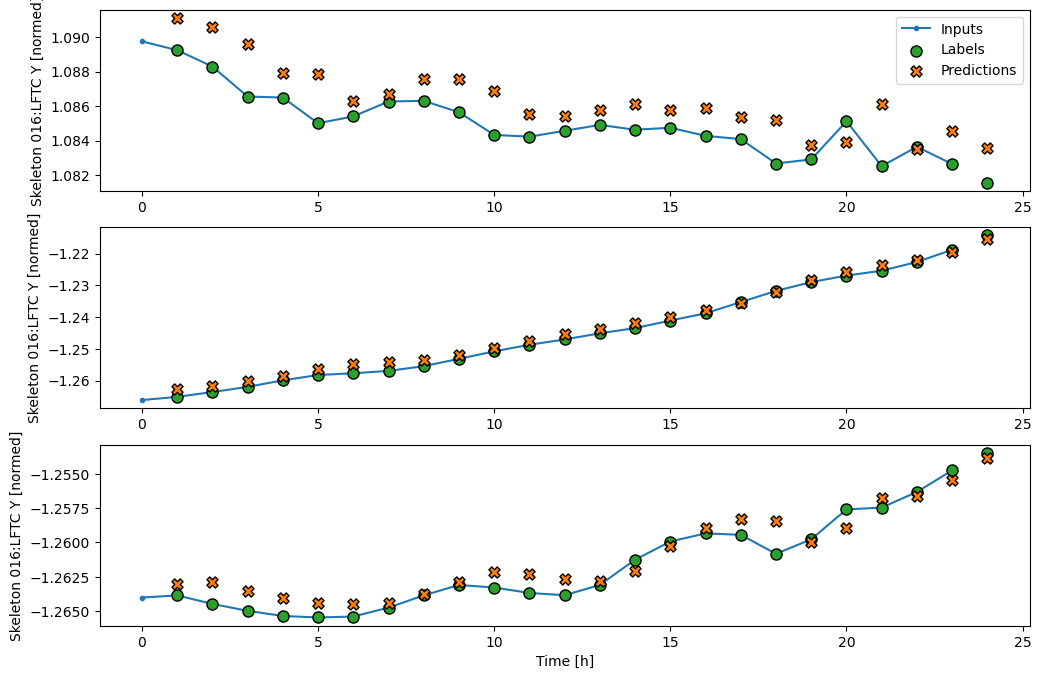

In [36]:
wide_window.plot(linear)

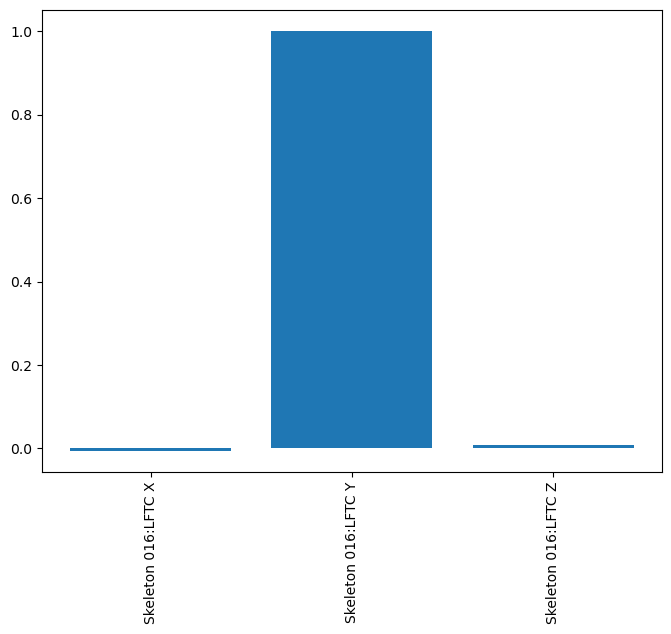

In [37]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Denso

In [39]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0686 - mean_absolute_error: 0.1026 - val_loss: 1.7407e-04 - val_mean_absolute_error: 0.0094
Epoch 2/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9784e-04 - mean_absolute_error: 0.0101 - val_loss: 1.5552e-04 - val_mean_absolute_error: 0.0090
Epoch 3/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9765e-04 - mean_absolute_error: 0.0103 - val_loss: 1.9313e-04 - val_mean_absolute_error: 0.0100
Epoch 4/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9795e-04 - mean_absolute_error: 0.0104 - val_loss: 2.0938e-04 - val_mean_absolute_error: 0.0110
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0986e-04 - mean_absolute_error: 0.0111


In [40]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Skeleton 016:LFTC Y'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Skeleton 016:LFTC Y']

Text(0.5, 1.0, 'Given 3 frames of inputs, predict 1 frames into the future.')

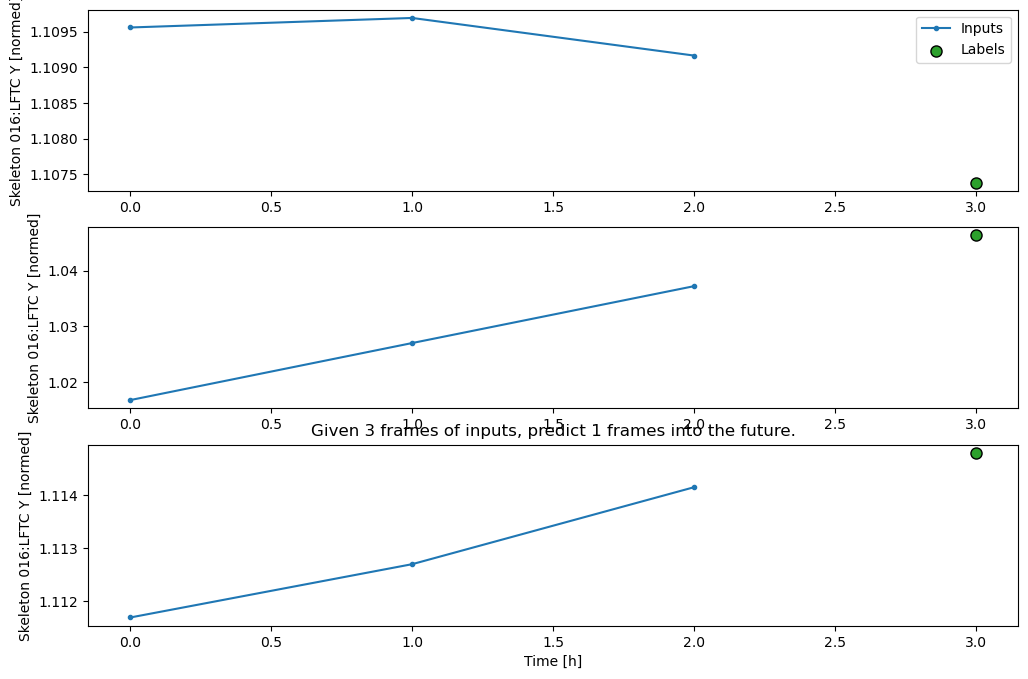

In [41]:
conv_window.plot()
plt.title("Given 3 frames of inputs, predict 1 frames into the future.")

Denso multi passos (3 para prever 1)

In [43]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [44]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1634 - mean_absolute_error: 0.1467 - val_loss: 4.7949e-04 - val_mean_absolute_error: 0.0165
Epoch 2/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7352e-04 - mean_absolute_error: 0.0141 - val_loss: 2.1603e-04 - val_mean_absolute_error: 0.0118
Epoch 3/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6027e-04 - mean_absolute_error: 0.0095 - val_loss: 1.1284e-04 - val_mean_absolute_error: 0.0072
Epoch 4/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1474e-04 - mean_absolute_error: 0.0079 - val_loss: 8.6167e-05 - val_mean_absolute_error: 0.0063
Epoch 5/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0853e-05 - mean_absolute_error: 0.0066 - val_loss: 8.8965e-05 - val_mean_absolute_error: 0.0069
Epoch 6/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5805e-05 - mean_absolute_error: 0.0066 - val_loss: 8.7545e-05 - val_mean_absolute_error: 0.0069
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 8.226

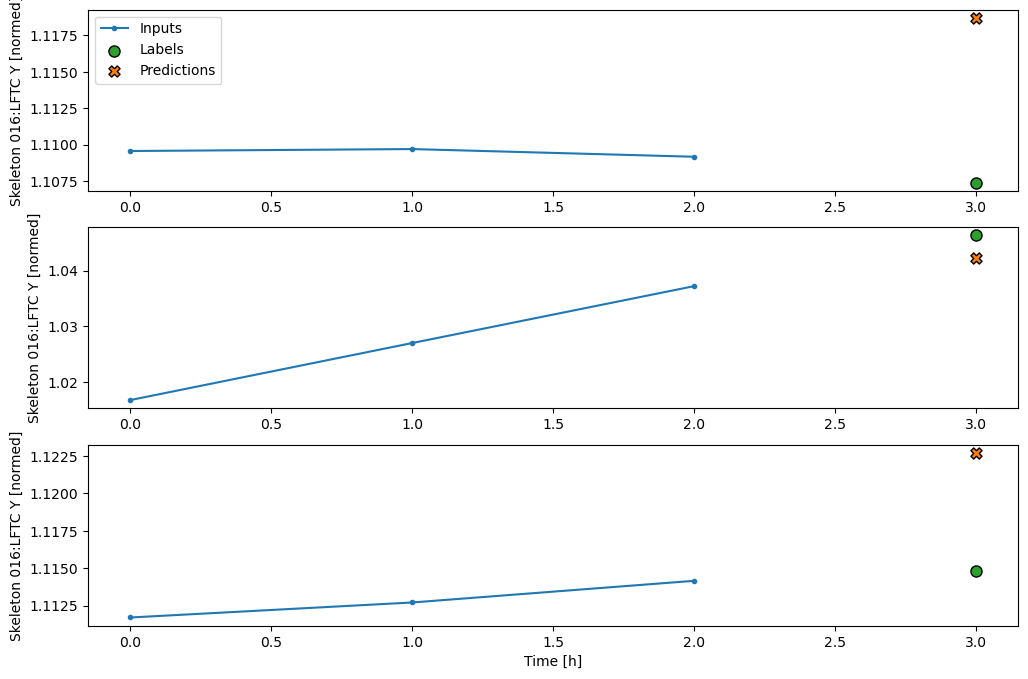

In [45]:
conv_window.plot(multi_step_dense)

Rede Neural de Convolução

In [47]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [48]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1172 - val_loss: 9.5148e-04 - val_mean_absolute_error: 0.0215
Epoch 2/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6524e-04 - mean_absolute_error: 0.0202 - val_loss: 6.4345e-04 - val_mean_absolute_error: 0.0200
Epoch 3/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6024e-04 - mean_absolute_error: 0.0162 - val_loss: 2.8339e-04 - val_mean_absolute_error: 0.0130
Epoch 4/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2492e-04 - mean_absolute_error: 0.0114 - val_loss: 1.0062e-04 - val_mean_absolute_error: 0.0069
Epoch 5/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0265e-04 - mean_absolute_error: 0.0077 - val_loss: 6.4468e-05 - val_mean_absolute_error: 0.0059
Epoch 6/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9785e-05 - mean_absolute_error: 0.0069 - val_loss: 9.1793e-05 - val_mean_absolute_error: 0.0075
Epoch 7/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [49]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Skeleton 016:LFTC Y'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Skeleton 016:LFTC Y']

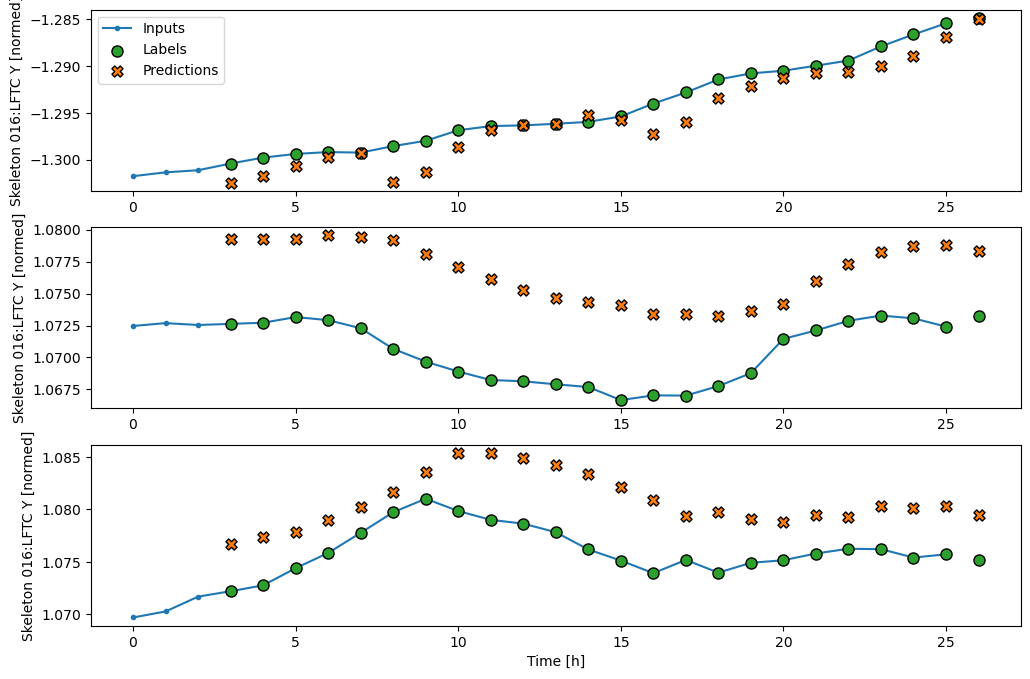

In [50]:
wide_conv_window.plot(conv_model)

RNN Rede Neural Recorrente

In [52]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [53]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1287 - mean_absolute_error: 0.2038 - val_loss: 0.0047 - val_mean_absolute_error: 0.0347
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0287 - val_loss: 8.4917e-04 - val_mean_absolute_error: 0.0162
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 9.1999e-04 - mean_absolute_error: 0.0151 - val_loss: 4.8560e-04 - val_mean_absolute_error: 0.0111
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5.2945e-04 - mean_absolute_error: 0.0107 - val_loss: 2.8344e-04 - val_mean_absolute_error: 0.0085
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.1505e-04 - mean_absolute_error: 0.0079 - val_loss: 1.5838e-04 - val_mean_absolute_error: 0.0064
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.8744e-04 - mean_absolute_error: 0.0063 - val_loss: 9.5241e-05 - val_mean_absolute_error: 0.0049
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.1

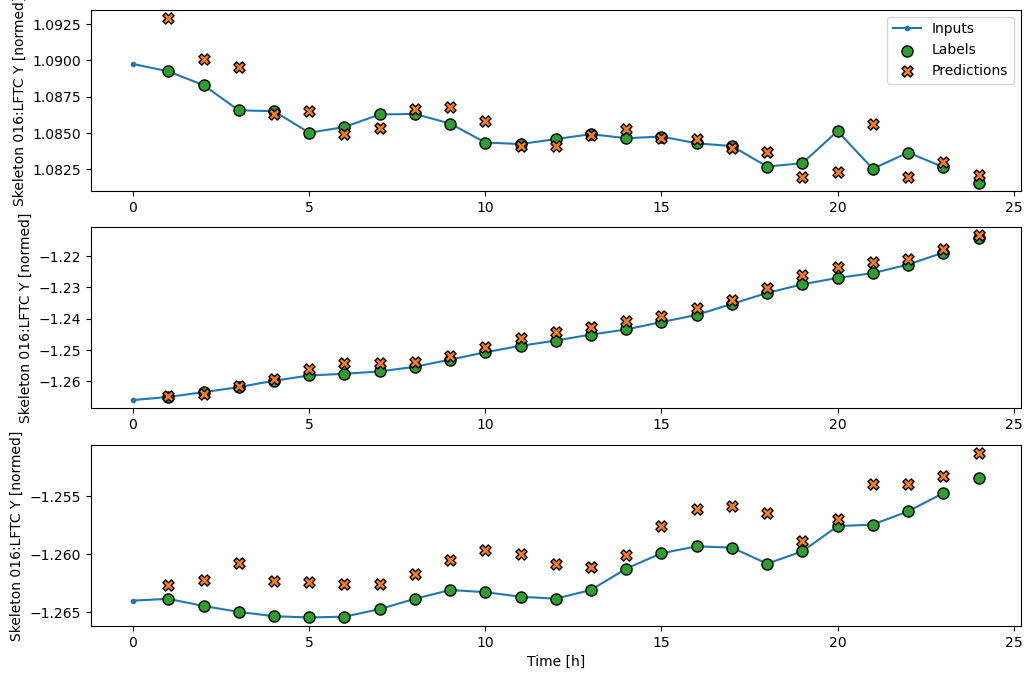

In [54]:
wide_window.plot(lstm_model)

In [55]:
lstm_model.metrics_names

['loss', 'compile_metrics']

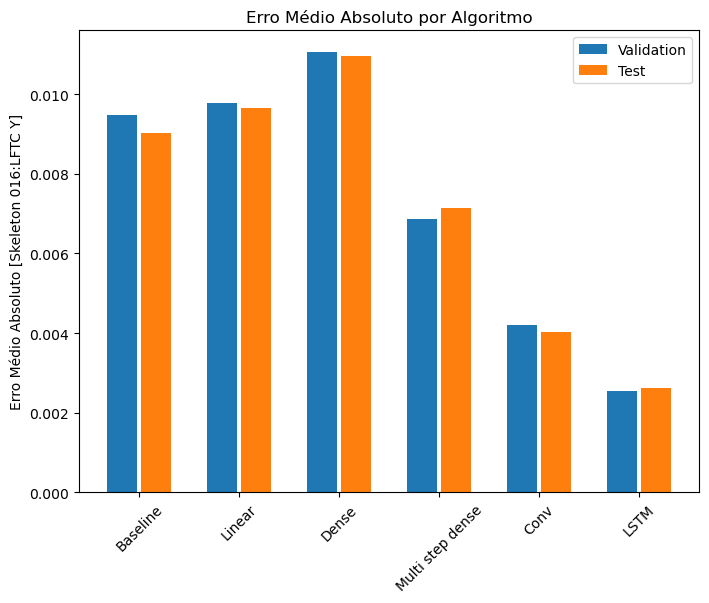

In [97]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'compile_metrics'
metric_index = lstm_model.metrics_names.index('compile_metrics')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.title('Erro Médio Absoluto por Algoritmo')
plt.ylabel('Erro Médio Absoluto [Skeleton 016:LFTC Y]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.show()

In [183]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0090
Linear      : 0.0098
Dense       : 0.0115
Multi step dense: 0.0062
Conv        : 0.0056
LSTM        : 0.0037


In [184]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 24, 3)


In [185]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [186]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 1.8722e-04 - mean_absolute_error: 0.0106


In [187]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [189]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.8169e-04 - mean_absolute_error: 0.0126 - val_loss: 1.5957e-04 - val_mean_absolute_error: 0.0098
Epoch 2/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0345e-04 - mean_absolute_error: 0.0112 - val_loss: 2.2979e-04 - val_mean_absolute_error: 0.0113
Epoch 3/20
839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1709e-04 - mean_absolute_error: 0.0117 - val_loss: 2.6983e-04 - val_mean_absolute_error: 0.0130
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7057e-04 - mean_absolute_error: 0.0131


In [190]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1603 - mean_absolute_error: 0.2342 - val_loss: 0.0084 - val_mean_absolute_error: 0.0442
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0056 - mean_absolute_error: 0.0370 - val_loss: 0.0015 - val_mean_absolute_error: 0.0223
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0203 - val_loss: 8.2584e-04 - val_mean_absolute_error: 0.0162
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.3733e-04 - mean_absolute_error: 0.0151 - val_loss: 5.0706e-04 - val_mean_absolute_error: 0.0124
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.5290e-04 - mean_absolute_error: 0.0116 - val_loss: 3.1435e-04 - val_mean_absolute_error: 0.0099
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.7813e-04 - mean_absolute_error: 0.0092 - val_loss: 2.0655e-04 - val_mean_absolute_error: 0.0086
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.8006e-04 -

Conexões Residuais: Prever a alteração, não o proximo valor

In [192]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [193]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.5691e-04 - mean_absolute_error: 0.0097 - val_loss: 7.0587e-05 - val_mean_absolute_error: 0.0058
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.7231e-05 - mean_absolute_error: 0.0057 - val_loss: 5.1359e-05 - val_mean_absolute_error: 0.0048
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.0964e-05 - mean_absolute_error: 0.0048 - val_loss: 4.4523e-05 - val_mean_absolute_error: 0.0044
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.3297e-05 - mean_absolute_error: 0.0043 - val_loss: 3.7968e-05 - val_mean_absolute_error: 0.0040
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.9234e-05 - mean_absolute_error: 0.0040 - val_loss: 3.3739e-05 - val_mean_absolute_error: 0.0038
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.6552e-05 - mean_absolute_error: 0.0039 - val_loss: 3.2411e-05 - val_mean_absolute_error: 0.0037
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step 

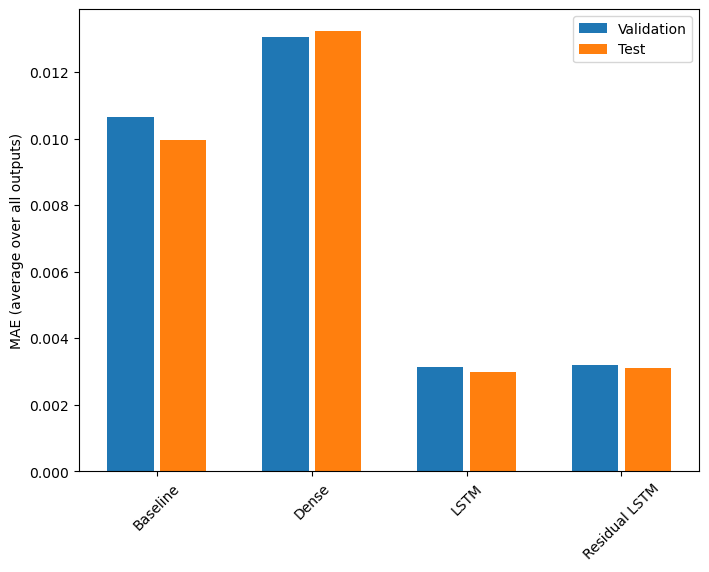

In [195]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'compile_metrics'
metric_index = lstm_model.metrics_names.index('compile_metrics')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [196]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0099
Dense          : 0.0132
LSTM           : 0.0030
Residual LSTM  : 0.0031


Previsão de Vários frames a frente

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

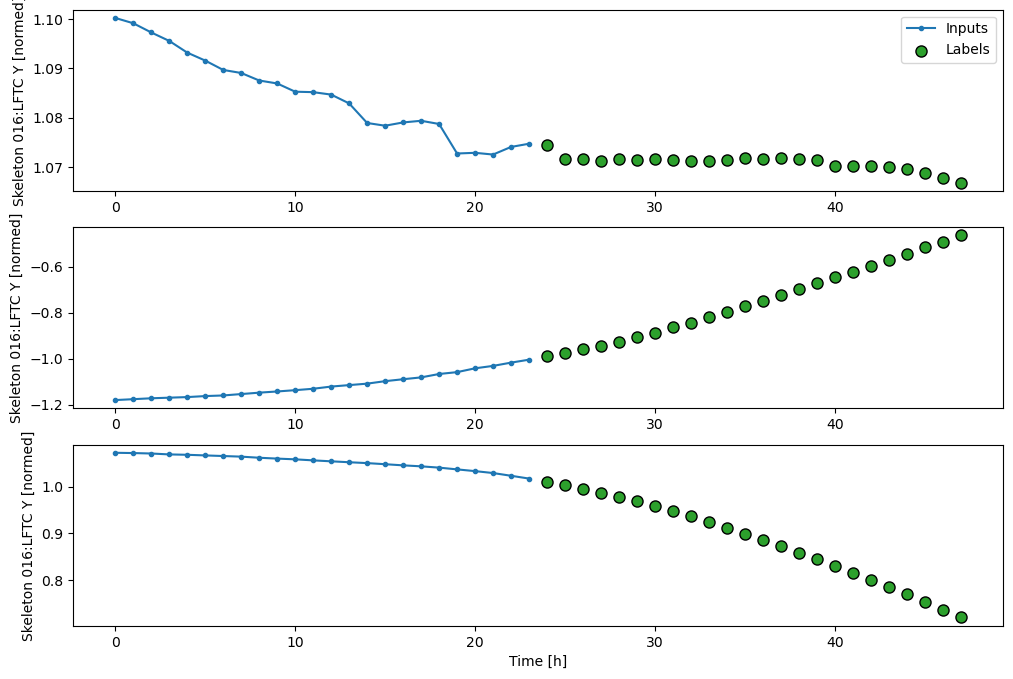

In [197]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Baseline

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367 - mean_absolute_error: 0.1310


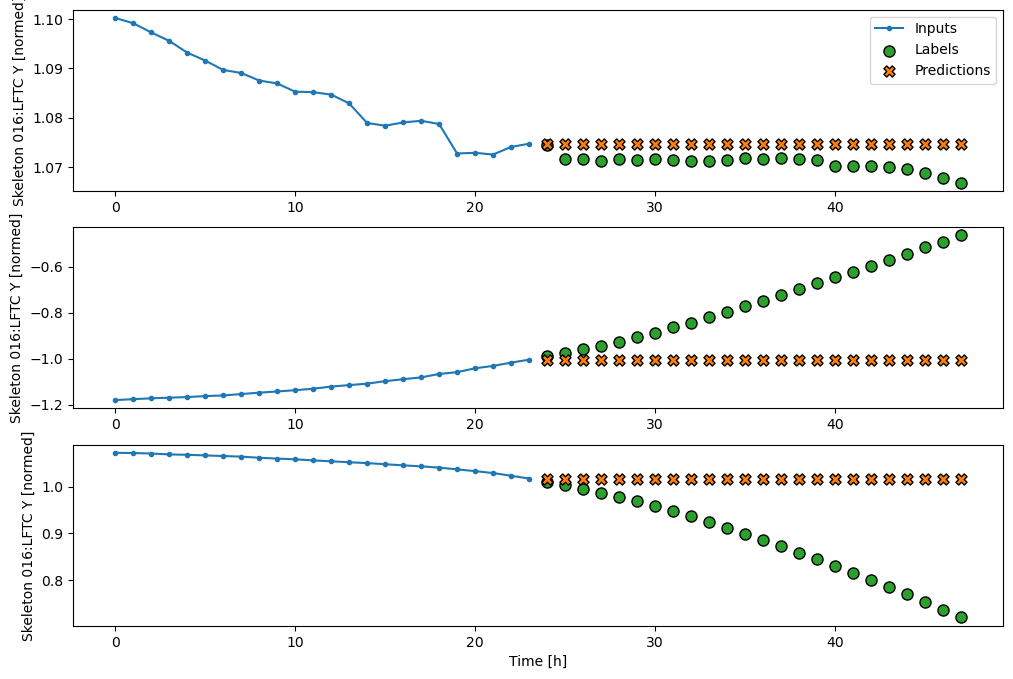

In [198]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.1048 - mean_absolute_error: 0.2548


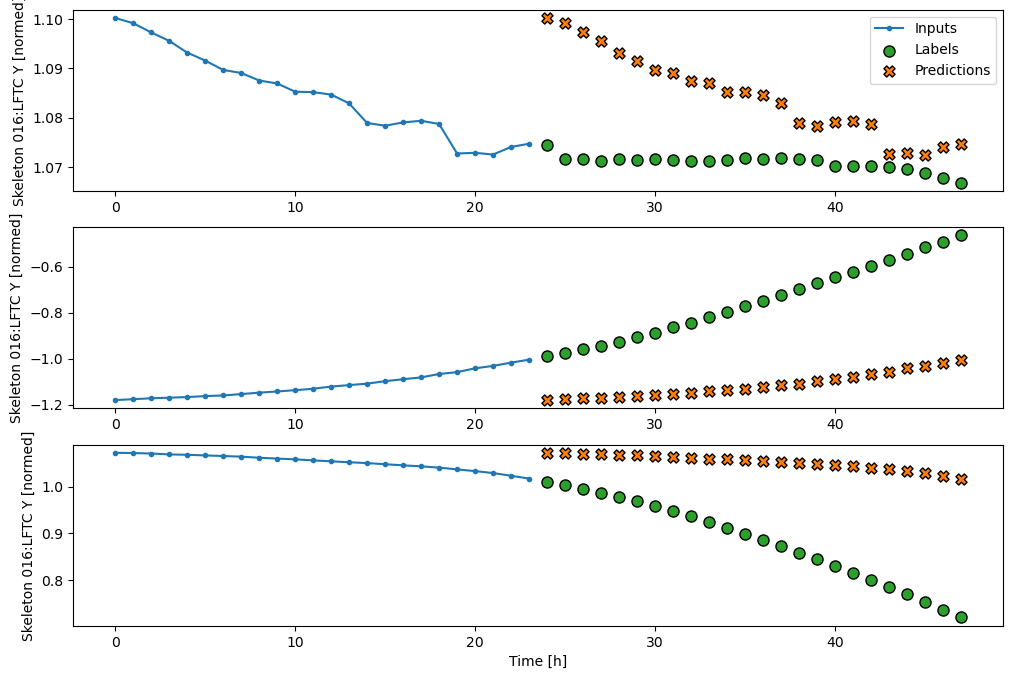

In [199]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Utiliza todo o Modelo para calcular o Futuro

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4371 - mean_absolute_error: 0.5413 - val_loss: 0.0635 - val_mean_absolute_error: 0.2027
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0568 - mean_absolute_error: 0.1838 - val_loss: 0.0530 - val_mean_absolute_error: 0.1831
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0478 - mean_absolute_error: 0.1670 - val_loss: 0.0442 - val_mean_absolute_error: 0.1627
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0412 - mean_absolute_error: 0.1514 - val_loss: 0.0394 - val_mean_absolute_error: 0.1474
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0379 - mean_absolute_error: 0.1411 - val_loss: 0.0373 - val_mean_absolute_error: 0.1387
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0363 - mean_absolute_error: 0.1353 - val_loss: 0.0363 - val_mean_absolute_error: 0.1345
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0355 - mean_absolute_error: 0.1318 - v

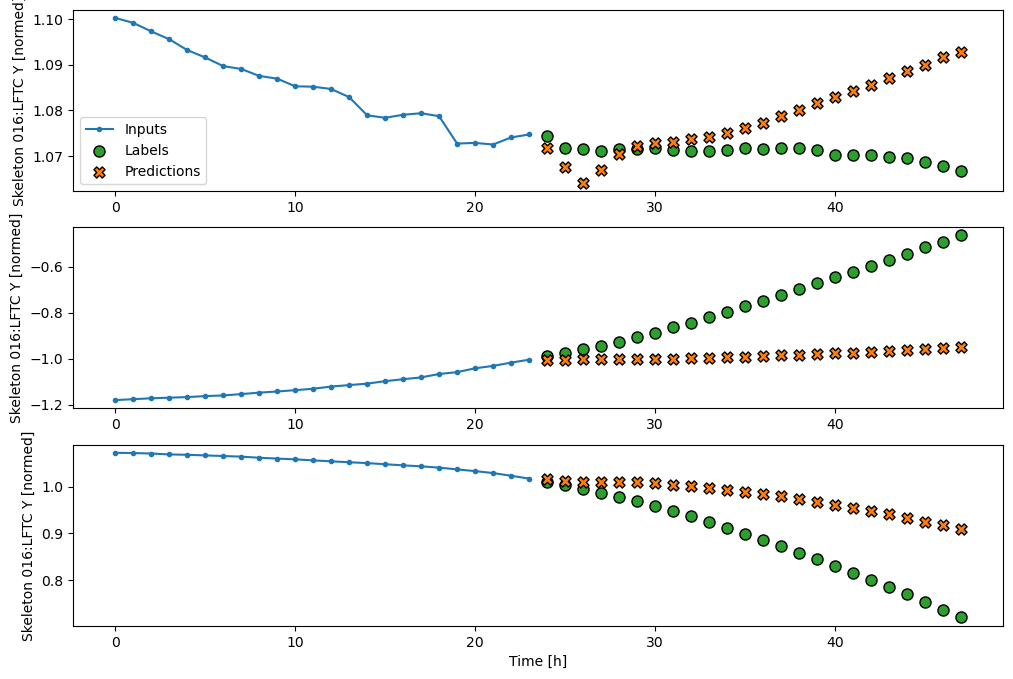

In [201]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Dense

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1080 - mean_absolute_error: 0.2157 - val_loss: 0.0346 - val_mean_absolute_error: 0.1339
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.1306 - val_loss: 0.0335 - val_mean_absolute_error: 0.1280
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0336 - mean_absolute_error: 0.1288 - val_loss: 0.0328 - val_mean_absolute_error: 0.1268
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0329 - mean_absolute_error: 0.1269 - val_loss: 0.0311 - val_mean_absolute_error: 0.1247
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0320 - mean_absolute_error: 0.1239 - val_loss: 0.0295 - val_mean_absolute_error: 0.1179
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0315 - mean_absolute_error: 0.1223 - val_loss: 0.0281 - val_mean_absolute_error: 0.1139
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0309 - mean_absolute_error: 0.1202 - v

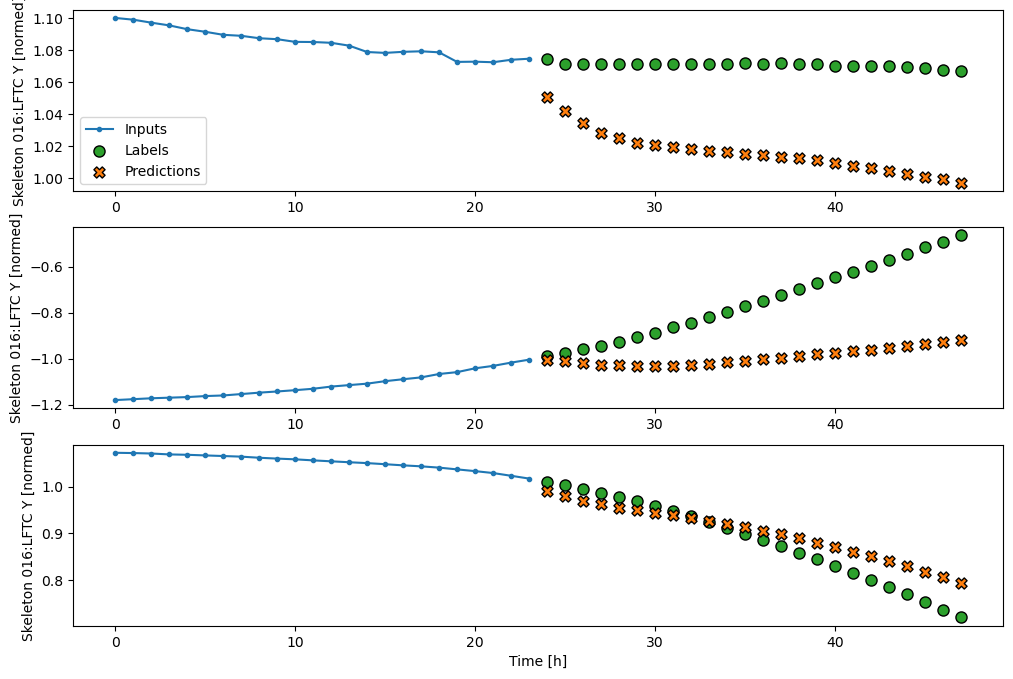

In [203]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

CNN

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1195 - mean_absolute_error: 0.2337 - val_loss: 0.0347 - val_mean_absolute_error: 0.1320
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0323 - mean_absolute_error: 0.1281 - val_loss: 0.0168 - val_mean_absolute_error: 0.0900
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0747 - val_loss: 0.0058 - val_mean_absolute_error: 0.0523
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0475 - val_loss: 0.0046 - val_mean_absolute_error: 0.0486
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0040 - mean_absolute_error: 0.0439 - val_loss: 0.0039 - val_mean_absolute_error: 0.0441
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0396 - val_loss: 0.0029 - val_mean_absolute_error: 0.0384
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0364 - v

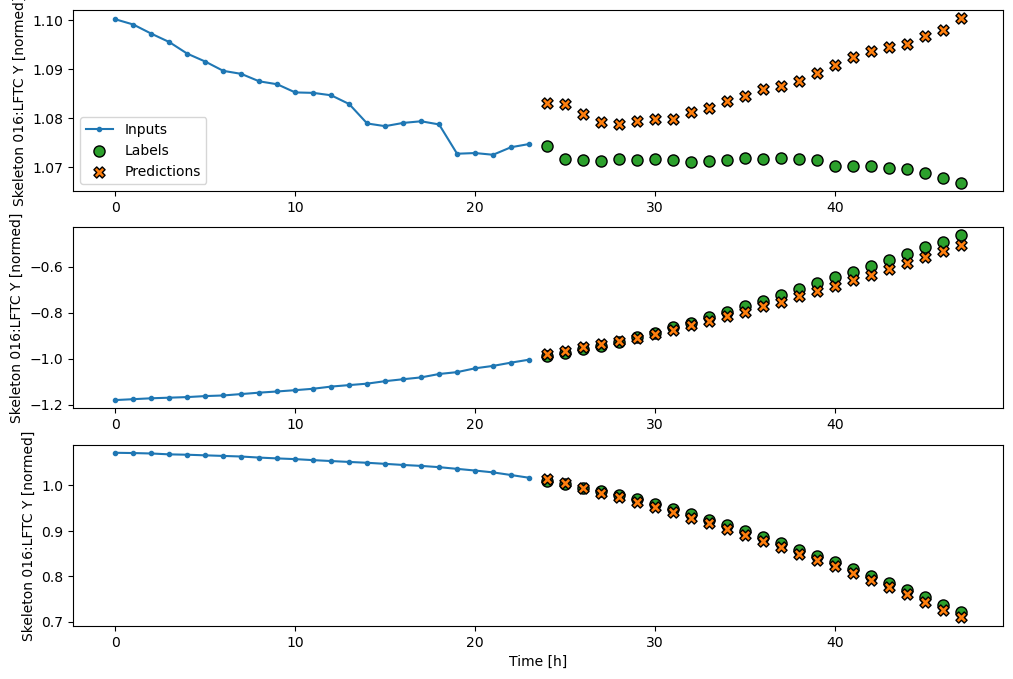

In [205]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

RNN

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1988 - mean_absolute_error: 0.3002 - val_loss: 0.0065 - val_mean_absolute_error: 0.0608
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0537 - val_loss: 0.0031 - val_mean_absolute_error: 0.0408
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0381 - val_loss: 0.0022 - val_mean_absolute_error: 0.0340
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0312 - val_loss: 0.0021 - val_mean_absolute_error: 0.0329
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0291 - val_loss: 0.0020 - val_mean_absolute_error: 0.0317
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0270 - val_loss: 0.0018 - val_mean_absolute_error: 0.0297
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0262 - v

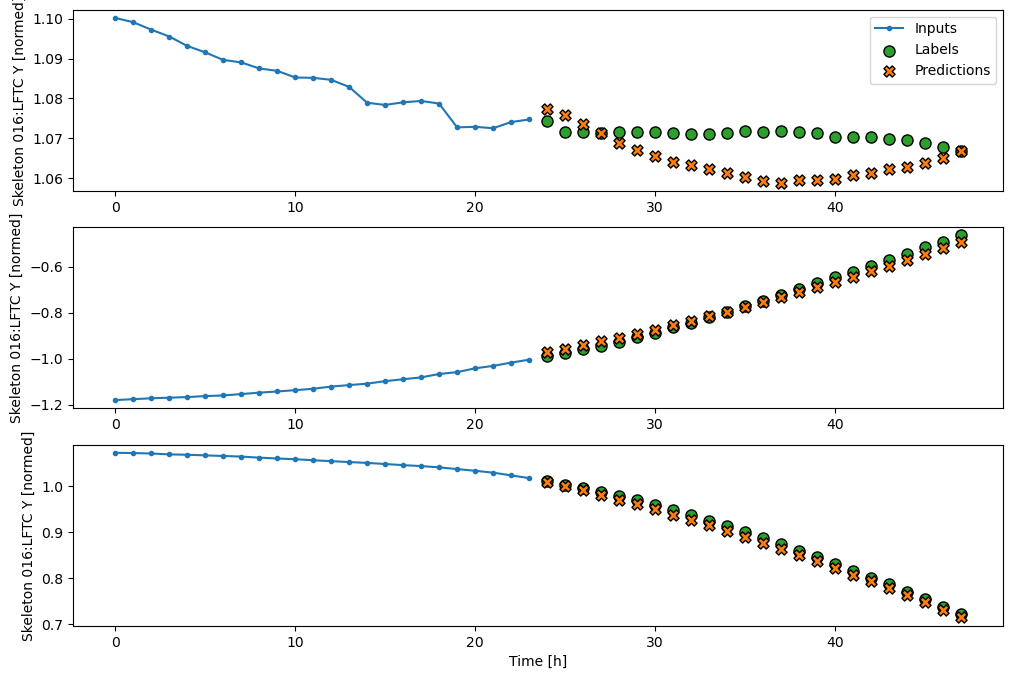

In [207]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

RNN autoregressivo ao inves de realizar predições direto, ele utiliza as predições para continuar treinando

In [210]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [211]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [212]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [214]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.1106 - mean_absolute_error: 0.2022 - val_loss: 0.0073 - val_mean_absolute_error: 0.0648
Epoch 2/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0594 - val_loss: 0.0042 - val_mean_absolute_error: 0.0487
Epoch 3/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0478 - val_loss: 0.0049 - val_mean_absolute_error: 0.0513
Epoch 4/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0445 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395
Epoch 5/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0410 - val_loss: 0.0053 - val_mean_absolute_error: 0.0537
Epoch 6/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0031 - mean_absolute_error: 0.0396 - val_loss: 0.0025 - val_mean_absolute_error: 0.0362
Epoch 7/20
838/838 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.03

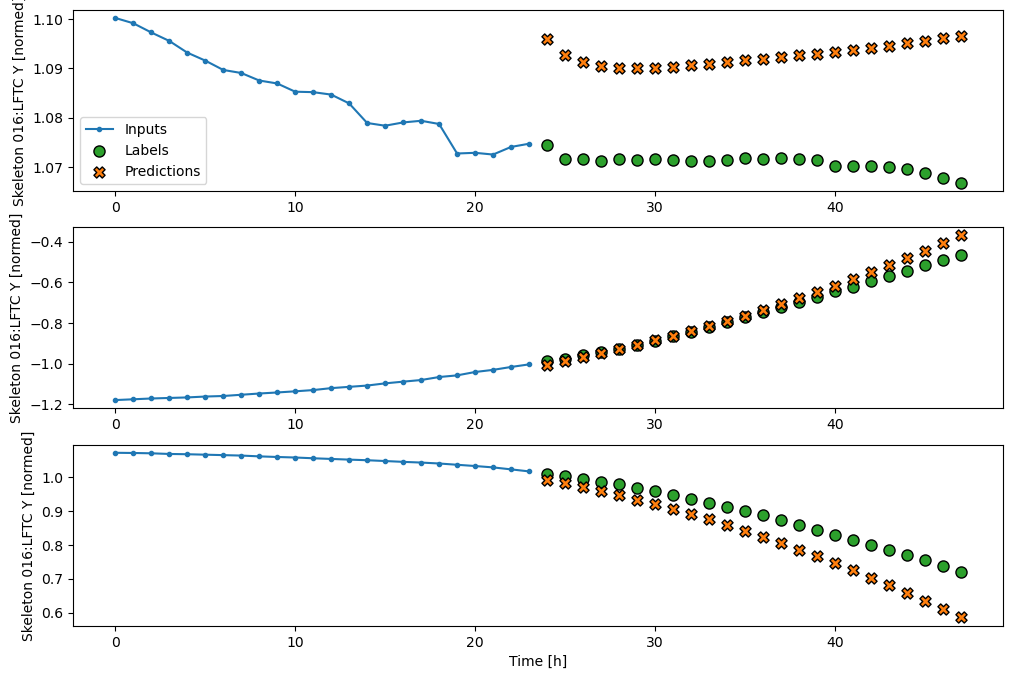

In [215]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

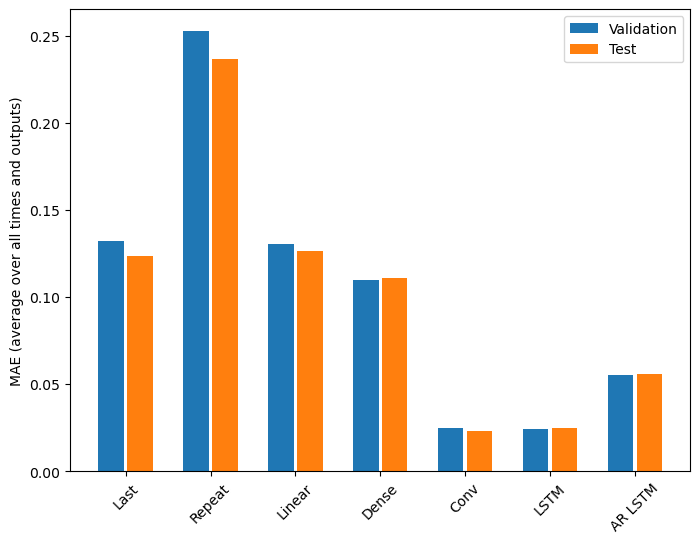

In [218]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'compile_metrics'
metric_index = lstm_model.metrics_names.index('compile_metrics')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()